In [2]:
import pandas as pd

data= pd.read_csv("indian_liver_patient - indian_liver_patient.csv")
df=data.copy()

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [3]:
df['Albumin_and_Globulin_Ratio']= df['Albumin_and_Globulin_Ratio'].fillna(df['Albumin_and_Globulin_Ratio'].median())

In [4]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

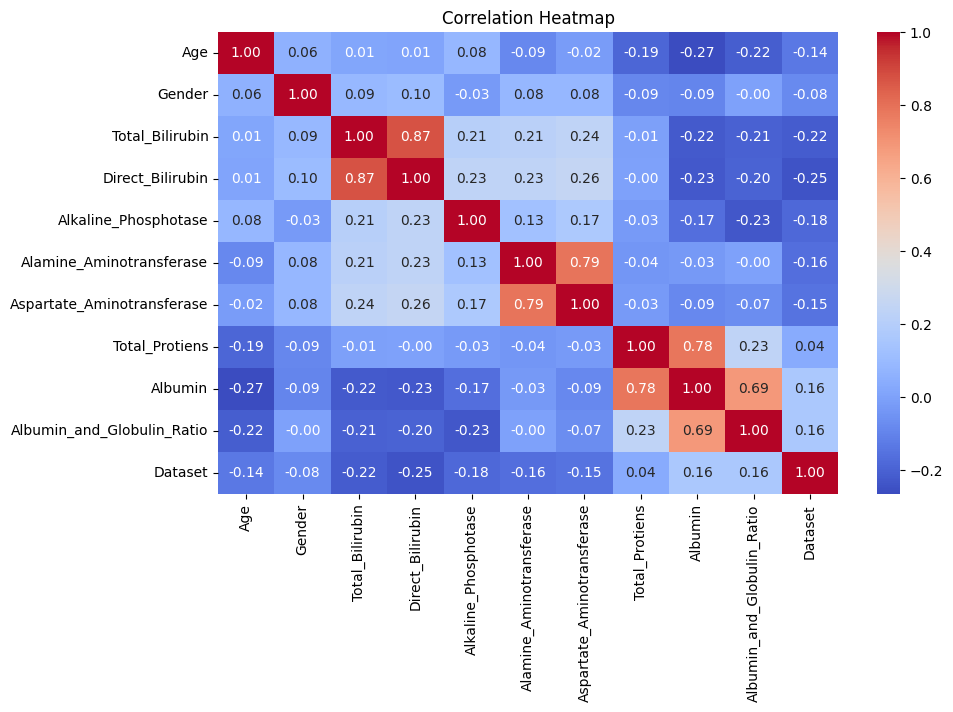

In [5]:
   
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

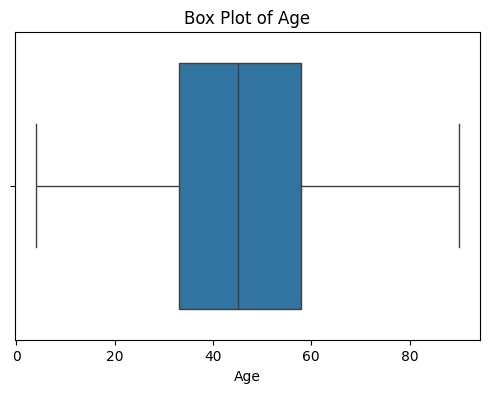

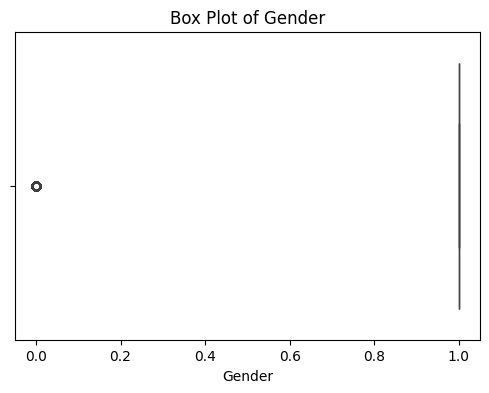

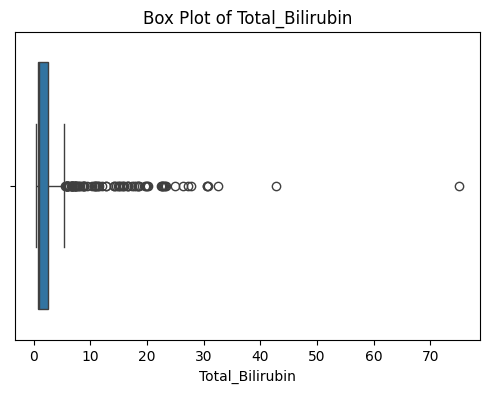

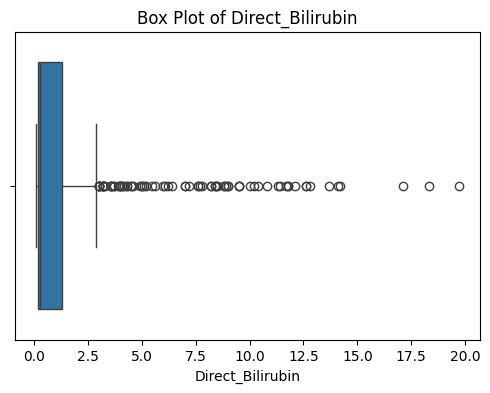

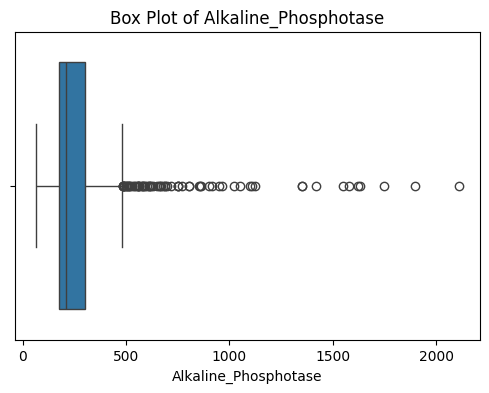

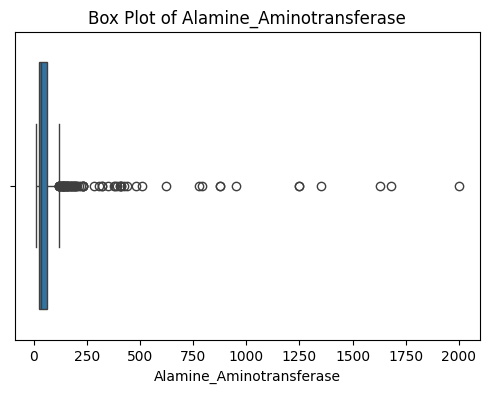

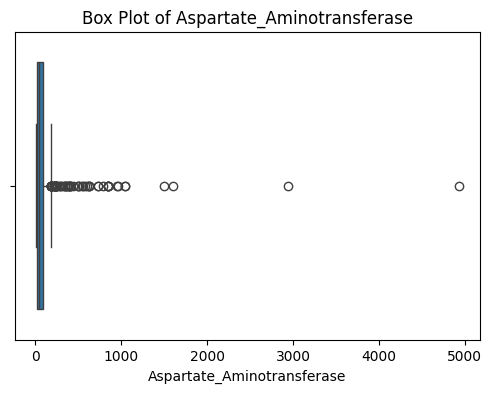

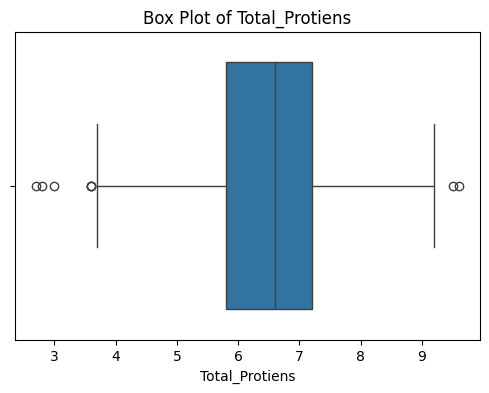

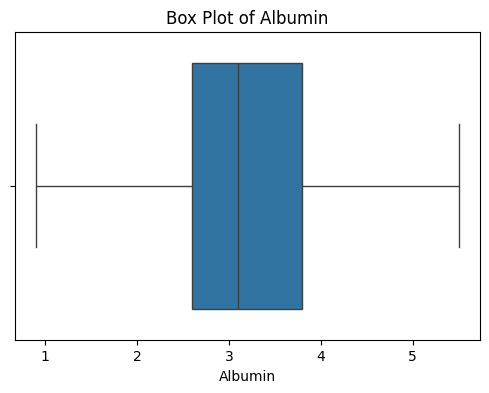

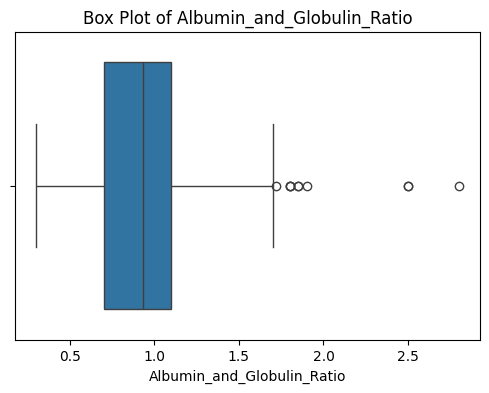

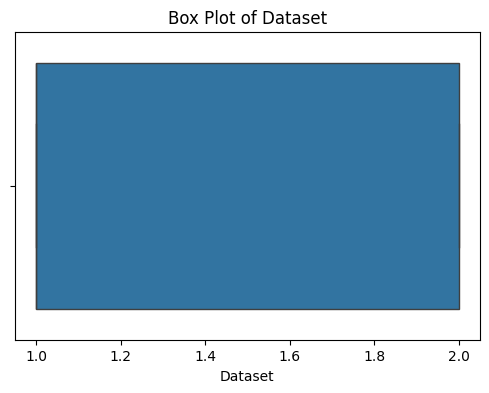

In [6]:
for col in df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Box Plot of {col}")
    plt.show()

In [5]:

df_liver= df.copy()


for col in df_liver: 
    Q1 = df_liver[col].quantile(0.25)
    Q3 = df_liver[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

 
    df_liver[col] = df_liver[col].clip(lower=lower_bound, upper=upper_bound)

print("Outliers capped. New shape:", df_liver.shape)


Outliers capped. New shape: (583, 11)


In [6]:
x = df_liver.drop(columns=["Dataset","Gender"])
y = df_liver["Dataset"].apply(lambda x: 1 if x == 2 else 0)


In [7]:
x.columns

Index(['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
       'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio'],
      dtype='object')

In [8]:
y

0      0
1      0
2      0
3      0
4      0
      ..
578    1
579    0
580    0
581    0
582    1
Name: Dataset, Length: 583, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42)

In [10]:
import numpy as np
import pickle


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


class_counts = np.bincount(y.astype(int)) 
imbalance_ratio = max(class_counts) / min(class_counts)

print("Class counts:", dict(enumerate(class_counts)))
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    main_metric = "F1"
    print("Dataset is imbalanced → using F1-score as main metric")
else:
    main_metric = "Accuracy"
    print("Dataset is balanced → using Accuracy as main metric")

# Models to test
models = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

results = []

trained_models = {}  # Store trained model objects


# Train & evaluate each model
for name, model in models.items():
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)

    trained_models[name] = model  # Store the trained model

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(ytest, y_pred),
        "Precision": precision_score(ytest, y_pred, average="weighted"),
        "Recall": recall_score(ytest, y_pred, average="weighted"),
        "F1": f1_score(ytest, y_pred, average="weighted")
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Sort by chosen main metric
df_results = df_results.sort_values(by=main_metric, ascending=False)
print("\n Model Performance Comparison:")
print(df_results)

# Best model
# Best model
best_model_name = df_results.iloc[0]["Model"]
best_model = trained_models[best_model_name]
print(f"\n Best model based on {main_metric}: {best_model_name}")


# Save the best model to a pickle file
with open("best_model_liver.pkl", "wb") as f:
    pickle.dump(best_model, f)
print(f" Best model saved as 'best_model.pkl'")

Class counts: {0: 416, 1: 167}
Imbalance ratio: 2.49
Dataset is imbalanced → using F1-score as main metric

 Model Performance Comparison:
                    Model  Accuracy  Precision    Recall        F1
1      LogisticRegression  0.743590   0.718477  0.743590  0.724916
0  DecisionTreeClassifier  0.709402   0.743090  0.709402  0.721299
3  RandomForestClassifier  0.717949   0.702843  0.717949  0.709067
2    KNeighborsClassifier  0.692308   0.685578  0.692308  0.688751

 Best model based on F1: LogisticRegression
 Best model saved as 'best_model.pkl'
